In [1]:
from glob import glob

# Data Manipulation
import numpy as np
import pandas as pd
from ete3 import Tree

# Statistics
from scipy.stats import t, spearmanr, pearsonr, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Counting number specI clusters in pipeline.

In [2]:
# Determining how many 97% OTUs we cover in total.
speci_to_otu_mapping = pd.read_csv("mapping_progenomes_v2.2_speci_clusters_to_mapref_v2.2b_OTUs.tsv", sep = "\t")

# These are clusters that are not taxonomically coherent according to GTDB.
problematic_clusters = ["specI_v3_Cluster22", "specI_v3_Cluster2375", "specI_v3_Cluster4851", "specI_v3_Cluster5010", "specI_v3_Cluster5514"]
problematic_genomes = ["1932669.SAMEA43981918", "550.SAMEA3856670", "1916230.SAMN05904579", "1618951.SAMN03319549", "1802238.SAMN04314631", "74031.SAMN03943304", "663.SAMN04088202"]

# specI mapping to a 96% OTU went into the pipeline. In addition, we don't consider specI cluster where
# the representative selected for the species tree turned out to be a chimera genome.
speci_clusters_in_pipeline = Tree("/Users/mdmit/Documents/hgt_project/file_repository/files_used_in_pipeline/species_tree_progenomes_v2.2_no_chimera_reps_only_mapping_to_otus.nwk").get_leaf_names()
speci_clusters_in_pipeline = ["specI_v3_" + x for x in speci_clusters_in_pipeline]
speci_clusters_in_pipeline = [x for x in speci_clusters_in_pipeline if x not in problematic_clusters]
print(len(speci_clusters_in_pipeline))

# Counting unique genomes bаsed on provided proGenomes specI cluster definition file.
list_of_genomes = pd.read_csv("combinedVsearch3.50p.20n.norm.opt.0.042.filteredBlackList.map", sep = "\t", header = None)
selected_genomes = [x for x in list(list_of_genomes.loc[list_of_genomes[0].isin(pd.Series(speci_clusters_in_pipeline)), 1].values) if x not in problematic_genomes]
print(len(selected_genomes))

# Now, looking at OTUs in pipeline.
otus_in_pipeline = speci_to_otu_mapping.loc[(speci_to_otu_mapping["speci_id"].isin(speci_clusters_in_pipeline)) & (speci_to_otu_mapping["OTU97"] != "unmapped"), "OTU97"].unique()
print(len(otus_in_pipeline))
otus_in_pipeline_short = [x[0] + x.split(";")[-1] for x in otus_in_pipeline]

8790
78315
4383


In [3]:
gtdb_taxonomy = pd.read_csv("mapping_progenomes_v2.2_genomes_to_GTDB_taxonomy_release95.tsv", sep = "\t")
print(gtdb_taxonomy.loc[gtdb_taxonomy["taxID.sampleID_Fr12"].isin(selected_genomes), "kingdom"].value_counts())
print(gtdb_taxonomy.loc[gtdb_taxonomy["specI_cluster"].isin(speci_clusters_in_pipeline), :].drop_duplicates("specI_cluster")["kingdom"].value_counts())

Bacteria    77591
Archaea       572
Name: kingdom, dtype: int64
Bacteria    8413
Archaea      329
Name: kingdom, dtype: int64


# Counting number of transfer events.

In [5]:
overview_transfer_events = pd.read_csv("gene_pairs_with_transfers_score_80_and_info_on_support_dist_and_seq_identity.tsv", sep = "\t")
overview_transfer_events.head()

/Users/mdmit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,family_id,node_id,min_support,speci_1,otu_1,genome_1,gene_1,speci_2,otu_2,genome_2,gene_2,speci_diff,gtdb_diff,otu_diff,distance,gene_distance,seq_identity,seq_coverage
0,1006004.SAMN02742621.GBAG_2392,1zibugxe,0.951,Cluster841,B16S;90_7;96_115;97_122,1914994.SAMN05970538,BMI79_10410,Cluster815,B16S;90_7;96_7;97_457,1006004.SAMN02742621,GBAG_2392,family,genus,96,0.2590,0.284,79.74,99.77
1,1006004.SAMN02742621.GBAG_2392,1zibugxe,0.951,Cluster839,B16S;90_7;96_115;97_357,1841657.SAMN04901303,A6U95_06030,Cluster815,B16S;90_7;96_7;97_457,1006004.SAMN02742621,GBAG_2392,family,genus,96,0.2671,0.279,80.05,99.77
2,103733.SAMN02645315.GCA_000716755_08369,ax8g9p5b,0.245,Cluster8873,B16S;90_14;96_441;97_712,1653480.SAMEA3392348,gene:80949765,Cluster3822,B16S;90_14;96_934;97_1085,40571.SAMN02645224,GCA_000719115_06218,genus,genus,96.0,0.5558,0.392,79.14,90.46
3,103733.SAMN02645315.GCA_000716755_08369,h034sp9r,0.754,Cluster11220,B16S;90_14;96_934;97_1085,446462.SAMN00001904,Amir_0118,Cluster6019,B16S;90_14;96_465;97_523,860235.SAMN03840758,AOZ06_00835,genus,genus,96.0,0.5596,0.363,80.02,90.46
4,103733.SAMN02645315.GCA_000716755_08369,h034sp9r,0.754,Cluster11220,B16S;90_14;96_934;97_1085,446462.SAMN00001904,Amir_0118,Cluster6017,B16S;90_14;96_465;97_523,38312.SAMN02645355,GCA_000720375_09402,order,genus,96.0,0.5381,0.305,81.61,90.46


In [6]:
# Let's look at the counts without some specI clusters that have incoherent GTDB taxonomy.
problematic_clusters_short = [x.split("_")[-1] for x in problematic_clusters]
overview_transfer_events = overview_transfer_events.loc[~(overview_transfer_events["genome_1"].isin(problematic_genomes)) & ~(overview_transfer_events["genome_2"].isin(problematic_genomes)), :]
overview_transfer_events = overview_transfer_events.loc[~(overview_transfer_events["speci_1"].isin(problematic_clusters_short)) & ~(overview_transfer_events["speci_2"].isin(problematic_clusters_short)), :]

In [7]:
# How many transfer events do we detect?
well_supported_transfer_events = overview_transfer_events.loc[overview_transfer_events["min_support"] >= 0.5, :]
(well_supported_transfer_events["family_id"] + well_supported_transfer_events["node_id"]).nunique()

2385585

In [8]:
# In how many gene families do we detect these transfer events?
well_supported_transfer_events["family_id"].nunique()

634352

In [9]:
# How many species have at least one transfer event detected?
pd.concat([well_supported_transfer_events["speci_1"], well_supported_transfer_events["speci_2"]]).nunique()

8756

In [10]:
# What percentage of species pairs have transferred genes between each other?
unique_species_pairs = well_supported_transfer_events.loc[:, ["speci_1", "speci_2"]].drop_duplicates()
combination_1 = unique_species_pairs["speci_1"] + unique_species_pairs["speci_2"]
combination_2 = unique_species_pairs["speci_2"] + unique_species_pairs["speci_1"]
unique_species_pairs["combo"] = np.minimum(combination_1, combination_2)
unique_species_pairs["combo"].nunique()
print(100 * (unique_species_pairs["combo"].nunique() / ((len(speci_clusters_in_pipeline) * (len(speci_clusters_in_pipeline) - 1))/2)))

4.379711892943022


In [11]:
# How many 98% identical transfers?
print(well_supported_transfer_events.loc[well_supported_transfer_events["seq_identity"] >= 98, "node_id"].nunique())
print(100*well_supported_transfer_events.loc[well_supported_transfer_events["seq_identity"] >= 98, "node_id"].nunique()/well_supported_transfer_events["node_id"].nunique())
# How many transfers with gene distance below 0.01?
print(well_supported_transfer_events.loc[well_supported_transfer_events["gene_distance"] <= 0.01, "node_id"].nunique())
print(100*well_supported_transfer_events.loc[well_supported_transfer_events["gene_distance"] <= 0.01, "node_id"].nunique()/well_supported_transfer_events["node_id"].nunique())

107705
4.514827396562016
70540
2.9569279472028653


# Counting 16S rRNA gene sequences.

In [16]:
# Counting unique genomes with 16S rRNA gene sequences based on provided proGenomes v2 file.
table_16S_sequences = pd.read_csv("summary_16SrRNA_onlyFr12_LEFTjoin_v1.txt", sep = "\t")
selected_coordinates = table_16S_sequences.loc[table_16S_sequences["taxID.sampleID_Fr12"].isin(selected_genomes), "contig_coordinate"]
selected_coordinates.loc[~(selected_coordinates.isna())].nunique()

149292

In [18]:
# How many genomes do these 16S rRNA gene sequences originate from?
len(list(list_of_genomes.loc[list_of_genomes[0].isin(speci_clusters_in_pipeline), 1].values))

78319

# Counting how many gene families with transfer are detected

In [19]:
# Uploading the complete dataset of genes that was used to generate pangenomes.
overview_all_genes_in_beginning = pd.read_csv("all_genes_in_dataset_to_95_representatives.tsv", sep = "\t", header = None)
overview_all_genes_in_beginning.columns = ["speci_id", "original_gene", "representative_95"]
overview_all_genes_in_beginning["genome"] = overview_all_genes_in_beginning["original_gene"].apply(lambda x: ".".join(x.split(".")[:2]))
overview_all_genes_in_beginning.head()

(290172551, 3)

In [21]:
# To do proper comparison, we need to look at gene families that actually made it through the pipeline.
# For those that didn't we can't say with 100% certainty whether a transfer event happened or not.
overview_of_genes_files = list(glob("*/overview_genes_after_pipeline.txt"))
genes_after_pipeline = pd.DataFrame()

for in_file in overview_of_genes_files:
    overview_for_subset = pd.read_csv(in_file, sep = " ")
    overview_for_subset.columns = ["family_id", "speci_id", "gene_id"]
    genes_after_pipeline = pd.concat([genes_after_pipeline, overview_for_subset])
genes_after_pipeline

,family_id,speci_id,gene_id
0,100053.SAMN02947772.GCA_002009845_00334,Cluster1377,1192864.SAMN02436412.LEP1GSC190_3347
1,100053.SAMN02947772.GCA_002009845_00334,Cluster1378,174.SAMN02947887.GCA_001568445_02882
2,100053.SAMN02947772.GCA_002009845_00334,Cluster1379,1192866.SAMN01036874.LEP1GSC133_2693
3,100053.SAMN02947772.GCA_002009845_00334,Cluster2,28184.SAMN02947820.GCA_001569365_00675
4,100053.SAMN02947772.GCA_002009845_00334,Cluster3,28184.SAMN02947818.GCA_001569375_02192
...,...,...,...
459307,999898.SAMN03754344.CEB3_c26520,Cluster12226,999898.SAMN03754344.CEB3_c26520
459308,999898.SAMN03754344.CEB3_c26520,Cluster2211,1121419.SAMN05443529.SAMN05443529_10140
459309,999898.SAMN03754344.CEB3_c26520,Cluster2212,768704.SAMN02261405.Desmer_3717
459310,999898.SAMN03754344.CEB3_c26520,Cluster5089,1633135.SAMN05356743.DSBG_4449


In [22]:
# Creating complete list of genes with a transfer event considered in the study.
genes_with_transfers = pd.concat([well_supported_transfer_events["genome_1"] + "." + well_supported_transfer_events["gene_1"], well_supported_transfer_events["genome_2"] + "." +  well_supported_transfer_events["gene_2"]]).unique()
only_98_genes = well_supported_transfer_events.loc[well_supported_transfer_events["seq_identity"] >= 98, :]
only_98_genes_with_transfers = pd.concat([only_98_genes["genome_1"] + "." + only_98_genes["gene_1"], only_98_genes["genome_2"] + "." +  only_98_genes["gene_2"]]).unique()

# Have to correct some typos in the gene_id.
genes_after_pipeline["gene_id"] = genes_after_pipeline["gene_id"].apply(lambda x: x.replace("___", "__"))
genes_with_transfers_corrected = [x.replace("___", "__") for x in genes_with_transfers]
only_98_genes_with_transfers_corrected = [x.replace("___", "__") for x in only_98_genes_with_transfers]

# In complete dataset, indicating whether gene has been transferred or not.
overview_all_genes_in_beginning["after_pipeline"] = overview_all_genes_in_beginning["representative_95"].isin(genes_after_pipeline["gene_id"])
overview_all_genes_in_beginning["transferred"] = overview_all_genes_in_beginning["representative_95"].isin(genes_with_transfers_corrected)
overview_all_genes_in_beginning["recently_transferred"] = overview_all_genes_in_beginning["representative_95"].isin(only_98_genes_with_transfers_corrected)

In [23]:
# Counting how many genes for each genome have made it through the complete pipeline and how many
# genes per genome have been transferred.
count_genes_per_genome = overview_all_genes_in_beginning.loc[overview_all_genes_in_beginning["after_pipeline"], "genome"].value_counts()
count_genes_with_transfer = overview_all_genes_in_beginning.loc[overview_all_genes_in_beginning["transferred"], "genome"].value_counts()
count_genes_with_recent_transfer = overview_all_genes_in_beginning.loc[overview_all_genes_in_beginning["recently_transferred"], "genome"].value_counts()
count_genes_per_genome

1463927.SAMN02645393    6942
936455.SAMN02441117     6882
546899.SAMN02441457     6867
1038862.SAMN02441026    6866
858423.SAMN05192541     6845
                        ... 
1394711.SAMN00998488       1
1415632.SAMN02441765       1
1053648.SAMN02604250       1
891398.SAMN02604228        1
1052801.SAMN02441387       1
Name: genome, Length: 78099, dtype: int64

In [24]:
count_genes_per_genome = count_genes_per_genome.loc[count_genes_per_genome.index.isin(selected_genomes)]
count_genes_with_transfer = count_genes_with_transfer.loc[count_genes_with_transfer.index.isin(selected_genomes)]
count_genes_with_recent_transfer = count_genes_with_recent_transfer.loc[count_genes_with_recent_transfer.index.isin(selected_genomes)]

### Fraction of genes transferred in each species.

In [25]:
# Counting how many genes have been transferred.
fraction_genes_transferred = count_genes_with_transfer/count_genes_per_genome
fraction_genes_transferred = fraction_genes_transferred.reset_index()
fraction_genes_transferred.columns = ["genome_id", "fraction_transferred"]

fraction_genes_transferred["genes_in_pipeline"] = fraction_genes_transferred["genome_id"].map(count_genes_per_genome)
fraction_genes_transferred["genes_transferred"] = fraction_genes_transferred["genome_id"].map(count_genes_with_transfer)
fraction_genes_transferred["genes_recently_transferred"] = fraction_genes_transferred["genome_id"].map(count_genes_with_recent_transfer)

fraction_genes_transferred.loc[fraction_genes_transferred["genes_transferred"].isna(), "genes_transferred"] = 0
fraction_genes_transferred.loc[fraction_genes_transferred["fraction_transferred"].isna(), "fraction_transferred"] = 0
fraction_genes_transferred.loc[fraction_genes_transferred["genes_recently_transferred"].isna(), "genes_recently_transferred"] = 0
fraction_genes_transferred["fraction_recent"] = fraction_genes_transferred["genes_recently_transferred"] / fraction_genes_transferred["genes_in_pipeline"]

list_of_genomes.columns = ["speci_id", "genome_id"]
fraction_genes_transferred = pd.merge(fraction_genes_transferred, list_of_genomes, how = 'left')
fraction_genes_transferred["number_genomes"] = fraction_genes_transferred["speci_id"].map(fraction_genes_transferred["speci_id"].value_counts())
fraction_genes_transferred

,genome_id,fraction_transferred,genes_in_pipeline,genes_transferred,genes_recently_transferred,fraction_recent,speci_id,number_genomes
0,100053.SAMN02947772,0.446854,2813,1257.0,45.0,0.015997,specI_v3_Cluster1,2
1,1000561.SAMN02471202,0.528046,1551,819.0,11.0,0.007092,specI_v3_Cluster201,2111
2,1000562.SAMN03114893,0.436187,619,270.0,2.0,0.003231,specI_v3_Cluster361,2
3,1000565.SAMN02471991,0.168955,1894,320.0,15.0,0.007920,specI_v3_Cluster371,2
4,1000568.SAMN00255229,0.259649,285,74.0,9.0,0.031579,specI_v3_Cluster564,3
...,...,...,...,...,...,...,...,...
78086,999630.SAMN02603093,0.377193,114,43.0,0.0,0.000000,specI_v3_Cluster12224,1
78087,999891.SAMN02603399,0.299699,1328,398.0,12.0,0.009036,specI_v3_Cluster281,139
78088,999892.SAMN02471992,0.306878,378,116.0,4.0,0.010582,specI_v3_Cluster6414,5
78089,999894.SAMN04623574,0.134328,67,9.0,0.0,0.000000,specI_v3_Cluster12225,1


In [26]:
fraction_genes_transferred_per_species = fraction_genes_transferred.groupby('speci_id').mean()
fraction_genes_transferred_per_species.loc[(fraction_genes_transferred_per_species["number_genomes"] >= 10) & (fraction_genes_transferred_per_species["fraction_transferred"] >= 0.6), :]
# specI_v3_Cluster259 - Acinetobacter baumanii
# specI_v3_Cluster201 - Pseudomonas aeruginosa
# specI_v3_Cluster95 - Escherichea coli
# specI_v3_Cluster85 - Klebsiella pneumoniae
# specI_v3_Cluster1211 - some Pseudomonas
# specI_v3_Cluster353 - Mycobacteroides abscessus

,fraction_transferred,genes_in_pipeline,genes_transferred,genes_recently_transferred,fraction_recent,number_genomes
speci_id,,,,,,
specI_v3_Cluster1211,0.767455,1798.574257,1380.049505,56.524752,0.031480,101.0
specI_v3_Cluster122,0.664134,1758.307692,1168.307692,120.230769,0.066547,13.0
specI_v3_Cluster1346,0.609379,1570.181818,956.818182,86.181818,0.054572,11.0
specI_v3_Cluster1350,0.600558,416.120690,249.827586,27.603448,0.065633,58.0
specI_v3_Cluster1385,0.624854,1864.437500,1164.687500,39.875000,0.021388,16.0
specI_v3_Cluster1386,0.656538,1278.166667,839.833333,52.055556,0.040840,18.0
specI_v3_Cluster1390,0.653195,3840.928571,2508.857143,73.571429,0.019075,14.0
specI_v3_Cluster1397,0.634129,3569.750000,2263.000000,109.916667,0.030626,12.0
specI_v3_Cluster154,0.764435,1909.500000,1461.333333,77.000000,0.040765,12.0


In [91]:
median_fraction = fraction_genes_transferred_per_species["fraction_transferred"].mean()
first_quartile = np.quantile(fraction_genes_transferred_per_species["fraction_transferred"].values, 0.25)
third_quartile = np.quantile(fraction_genes_transferred_per_species["fraction_transferred"].values, 0.75)
print(round(100*median_fraction, 1), round(100*first_quartile, 1), round(100*third_quartile, 1))

42.5 34.9 50.5


## Investigating whether number of transfers detected is related to number of studies species or genome size.

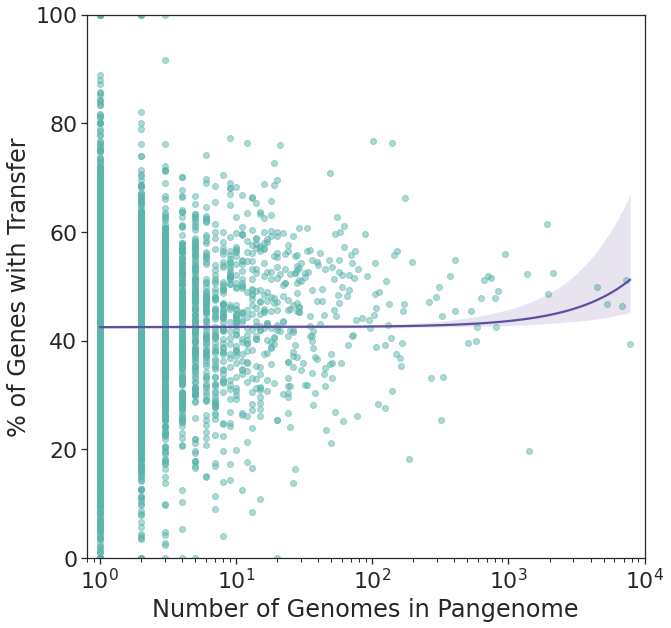

In [61]:
sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(1, 1, figsize = (10, 10))
sns.regplot(x = fraction_genes_transferred_per_species["number_genomes"], y = 100*fraction_genes_transferred_per_species["fraction_transferred"], line_kws = {"color": "#604EA0"}, scatter_kws = {"color": "#5ab4ac", "alpha": 0.5}, ax = axes)
axes.set(xlabel = "Number of Genomes in Pangenome", ylabel = "% of Genes with Transfer", ylim = [0, 100], xlim = [0.8, 10000])
axes.set_xscale("log")

In [29]:
spearmanr(fraction_genes_transferred_per_species["number_genomes"], fraction_genes_transferred_per_species["fraction_transferred"])

SpearmanrResult(correlation=0.038693969441955335, pvalue=0.0002881749131368111)

In [44]:
pearsonr(fraction_genes_transferred_per_species["number_genomes"], fraction_genes_transferred_per_species["fraction_transferred"])

(0.014671828601041796, 0.16933627865973155)

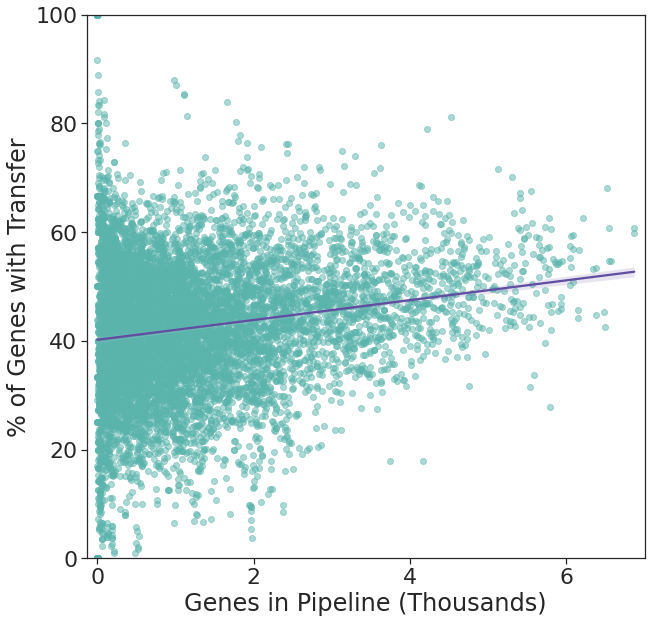

In [62]:
sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(1, 1, figsize = (10, 10))
sns.regplot(x = fraction_genes_transferred_per_species["genes_in_pipeline"]/1000, y = 100*fraction_genes_transferred_per_species["fraction_transferred"], line_kws = {"color": "#604EA0"}, scatter_kws = {"color": "#5ab4ac", "alpha": 0.5}, ax = axes)
    
axes.set(xlabel = "Genes in Pipeline (Thousands)", ylabel = "% of Genes with Transfer", ylim = [0, 100], xlim = [-0.134, 7], xticks = [0, 2, 4, 6])

In [31]:
spearmanr(fraction_genes_transferred_per_species["genes_in_pipeline"], fraction_genes_transferred_per_species["fraction_transferred"])

SpearmanrResult(correlation=0.13647628411290155, pvalue=9.360483032920763e-38)

In [43]:
pearsonr(fraction_genes_transferred_per_species["genes_in_pipeline"], fraction_genes_transferred_per_species["fraction_transferred"])

(0.1786952697891961, 7.010630239613297e-64)

## Investigating whether the number of genes transferred is associated to environmental preferences.

In [63]:
otu_relative_abundances = pd.read_csv("OTU_average_abundance_by_environment.csv", sep = ",")
otu_relative_abundances["pref_env"] = otu_relative_abundances.loc[: , ["animal", "aquatic", "plant", "soil"]].idxmax(axis = 1)
otu_relative_abundances["max_abund"] = otu_relative_abundances.loc[: , ["animal", "aquatic", "plant", "soil"]].max(axis = 1)
speci_to_otu_mapping_with_env = speci_to_otu_mapping.merge(otu_relative_abundances.loc[:, ["otu_id", "pref_env", "max_abund"]], left_on = "OTU97", right_on = "otu_id")
speci_to_otu_mapping_with_env.head()

,speci_id,OTU90,OTU96,OTU97,OTU98,OTU99,otu_id,pref_env,max_abund
0,specI_v3_Cluster1,B16S;90_34,B16S;90_34;96_47,B16S;90_34;96_47;97_49,B16S;90_34;96_47;97_49;98_53,B16S;90_34;96_47;97_49;98_53;99_550,B16S;90_34;96_47;97_49,aquatic,0.000002
1,specI_v3_Cluster10820,B16S;90_34,B16S;90_34;96_47,B16S;90_34;96_47;97_49,B16S;90_34;96_47;97_49;98_53,B16S;90_34;96_47;97_49;98_53;99_550,B16S;90_34;96_47;97_49,aquatic,0.000002
2,specI_v3_Cluster1377,B16S;90_34,B16S;90_34;96_47,B16S;90_34;96_47;97_49,B16S;90_34;96_47;97_49;98_53,B16S;90_34;96_47;97_49;98_53;99_550,B16S;90_34;96_47;97_49,aquatic,0.000002
3,specI_v3_Cluster1378,B16S;90_34,B16S;90_34;96_47,B16S;90_34;96_47;97_49,B16S;90_34;96_47;97_49;98_53,B16S;90_34;96_47;97_49;98_53;99_550,B16S;90_34;96_47;97_49,aquatic,0.000002
4,specI_v3_Cluster1379,B16S;90_34,B16S;90_34;96_47,B16S;90_34;96_47;97_49,B16S;90_34;96_47;97_49;98_53,B16S;90_34;96_47;97_49;98_53;99_550,B16S;90_34;96_47;97_49,aquatic,0.000002


In [64]:
map_speci_to_environments = speci_to_otu_mapping_with_env.sort_values("max_abund", ascending = False)
map_speci_to_environments = map_speci_to_environments.loc[:, ["speci_id", "pref_env"]].drop_duplicates("speci_id")
map_speci_to_environments.index = map_speci_to_environments["speci_id"]
map_speci_to_environments = map_speci_to_environments["pref_env"]
fraction_genes_transferred_per_species["pref_env"] = fraction_genes_transferred_per_species.index.map(map_speci_to_environments)
fraction_genes_transferred_per_species

,fraction_transferred,genes_in_pipeline,genes_transferred,genes_recently_transferred,fraction_recent,number_genomes,pref_env
speci_id,,,,,,,
specI_v3_Cluster1,0.437248,2944.00,1286.00,45.50,0.015478,2.0,aquatic
specI_v3_Cluster10,0.625290,3013.00,1884.00,32.00,0.010621,1.0,plant
specI_v3_Cluster100,0.454570,3538.50,1608.50,82.00,0.023171,2.0,animal
specI_v3_Cluster10000,0.413793,377.00,156.00,0.00,0.000000,1.0,animal
specI_v3_Cluster10001,0.480826,339.00,163.00,0.00,0.000000,1.0,animal
...,...,...,...,...,...,...,...
specI_v3_Cluster999,0.393777,870.75,342.75,8.25,0.009442,4.0,animal
specI_v3_Cluster9995,0.336973,641.00,216.00,3.00,0.004680,1.0,animal
specI_v3_Cluster9996,0.189369,2107.00,399.00,1.00,0.000475,1.0,animal


In [71]:
# To keep a defined order of environments on box plot, need to change data type to categorical.
environments = ["animal", "aquatic", "plant", "soil"]
cat_type = pd.CategoricalDtype(categories = environments, ordered = True)
fraction_genes_transferred_per_species["pref_env"] = fraction_genes_transferred_per_species["pref_env"].astype(cat_type)

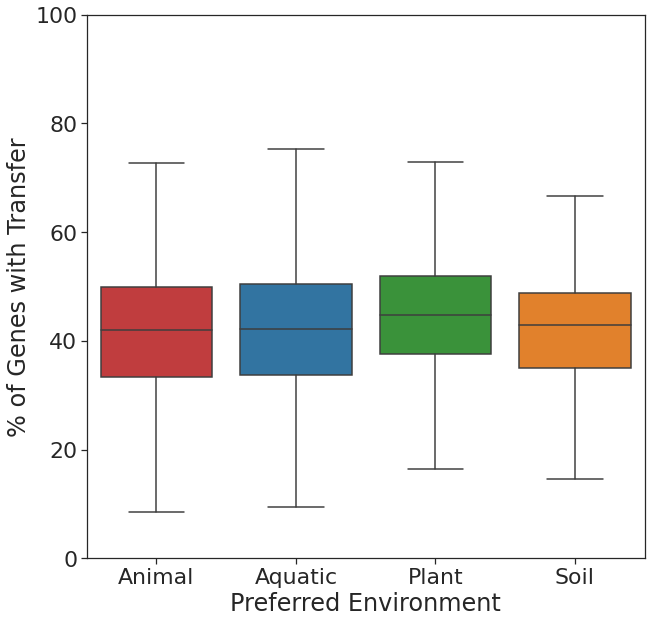

In [87]:
sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(1, 1, figsize = (10, 10))
sns.boxplot(x = fraction_genes_transferred_per_species["pref_env"], y = 100*fraction_genes_transferred_per_species["fraction_transferred"], palette = ["#D62728", "#1F77B4", "#2CA02C", "#FF7F0E"], showfliers = False, ax = axes)
axes.set(xlabel = "Preferred Environment", ylabel = "% of Genes with Transfer", ylim = [0, 100], xticklabels = ["Animal", "Aquatic", "Plant", "Soil"])

In [89]:
environments = ["animal", "aquatic", "plant", "soil"]
env_combo = []
fraction_transferred_pvalue = []

for env_1 in range(len(environments) - 1):
    for env_2 in range(env_1+1, len(environments)):
            env_combo.append(environments[env_1] + "\t" + environments[env_2])
            
            data_env_1 = fraction_genes_transferred_per_species.loc[fraction_genes_transferred_per_species["pref_env"] == environments[env_1], "fraction_transferred"].dropna()
            data_env_2 = fraction_genes_transferred_per_species.loc[fraction_genes_transferred_per_species["pref_env"] == environments[env_2], "fraction_transferred"].dropna()
            fraction_transferred_pvalue.append(mannwhitneyu(data_env_1, data_env_2)[1])

fraction_transferred_pvalue = multipletests(fraction_transferred_pvalue)[1]
for i in range(len(env_combo)):
                print("{}\t{:.2e}\t{}".format(env_combo[i], fraction_transferred_pvalue[i], fraction_transferred_pvalue[i] < 0.001))

animal	aquatic	2.04e-01	False
animal	plant	3.04e-16	True
animal	soil	2.71e-01	False
aquatic	plant	2.62e-13	True
aquatic	soil	4.94e-01	False
plant	soil	1.62e-09	True


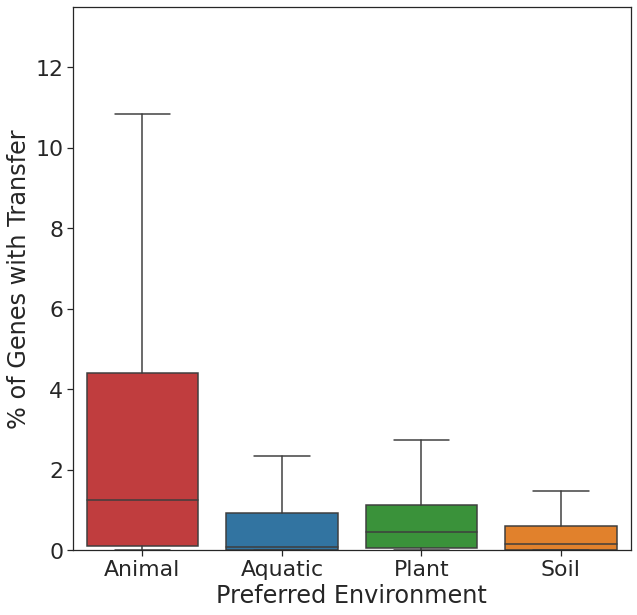

In [85]:
sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(1, 1, figsize = (10, 10))
sns.boxplot(x = fraction_genes_transferred_per_species["pref_env"], y = 100*fraction_genes_transferred_per_species["fraction_recent"], palette = ["#D62728", "#1F77B4", "#2CA02C", "#FF7F0E"], showfliers = False)
axes.set(xlabel = "Preferred Environment", ylabel = "% of Genes with Transfer", ylim = [0, 13.5], xticklabels = ["Animal", "Aquatic", "Plant", "Soil"])

In [88]:
environments = ["animal", "aquatic", "plant", "soil"]
env_combo = []
fraction_recent_pvalue = []

for env_1 in range(len(environments) - 1):
    for env_2 in range(env_1+1, len(environments)):
            env_combo.append(environments[env_1] + "\t" + environments[env_2])
            
            data_env_1 = fraction_genes_transferred_per_species.loc[fraction_genes_transferred_per_species["pref_env"] == environments[env_1], "fraction_recent"].dropna()
            data_env_2 = fraction_genes_transferred_per_species.loc[fraction_genes_transferred_per_species["pref_env"] == environments[env_2], "fraction_recent"].dropna()
            fraction_recent_pvalue.append(mannwhitneyu(data_env_1, data_env_2)[1])

fraction_recent_pvalue = multipletests(fraction_recent_pvalue)[1]
for i in range(len(env_combo)):
                print("{}\t{:.2e}\t{}".format(env_combo[i], fraction_recent_pvalue[i], fraction_recent_pvalue[i] < 0.001))

animal	aquatic	2.65e-129	True
animal	plant	1.81e-56	True
animal	soil	2.14e-88	True
aquatic	plant	2.25e-43	True
aquatic	soil	1.50e-01	False
plant	soil	3.98e-31	True
